In [5]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from dask.distributed import Client
import pprint 
# functions.ipynb contains functions to calculate ozone in dobzon units from mol/mol and the weight calculator
%run /home/jovyan/escience-2022/Tjaernoe2022-group2/notebooks/func.ipynb
%run /home/jovyan/escience-2022/Tjaernoe2022-group2/Emma/CMIP6_func.ipynb
%matplotlib inline

In [6]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:37977")
client

<Client: 'tcp://127.0.0.1:37977' processes=5 threads=20, memory=78.51 GiB>

In [352]:
waccm = xr.open_dataset('ds_waccm_1986_1996.nc')
cam = xr.open_dataset('ds_cam_1986_1996.nc')


In [353]:
ds_waccm_o3 = calculate_total_ozone_p(waccm).totO3
ds_cam_o3 = calculate_total_ozone_p(cam).totO3

Minimum column ozone value: 77.58066507113938
Minimum column ozone value: 123.06982718972165


In [354]:
ds_waccm_anom = calc_monthly_anomaly(ds_waccm_o3,1991)
ds_cam_anom = calc_monthly_anomaly(ds_cam_o3,1991)

In [355]:
# Calculate the weight for the northern and southern hemispheres
# WACCM
waccm_NH_anom = computeWeightedMean(ds_waccm_anom.where(ds_waccm_anom['lat']>60.)).compute()
waccm_SH_anom = computeWeightedMean(ds_waccm_anom.where(ds_waccm_anom['lat']<-60.)).compute()

# CAM
cam_NH_anom = computeWeightedMean(ds_cam_anom.where(ds_cam_anom['lat']>60.)).compute()
cam_SH_anom = computeWeightedMean(ds_cam_anom.where(ds_cam_anom['lat']<-60.)).compute()

In [366]:
waccm_NH_anom.isel(time=[12*6])

<xarray.DataArray 'totO3' (member_id: 1, time: 1)>
array([[6.05004971]])
Coordinates:
  * time       (time) object 1991-01-15 12:00:00
  * member_id  (member_id) object 'r1i1p1f1'
    month      (time) int64 1
Attributes:
    units:      DU
    long_name:  Column ozone in Dobson Units

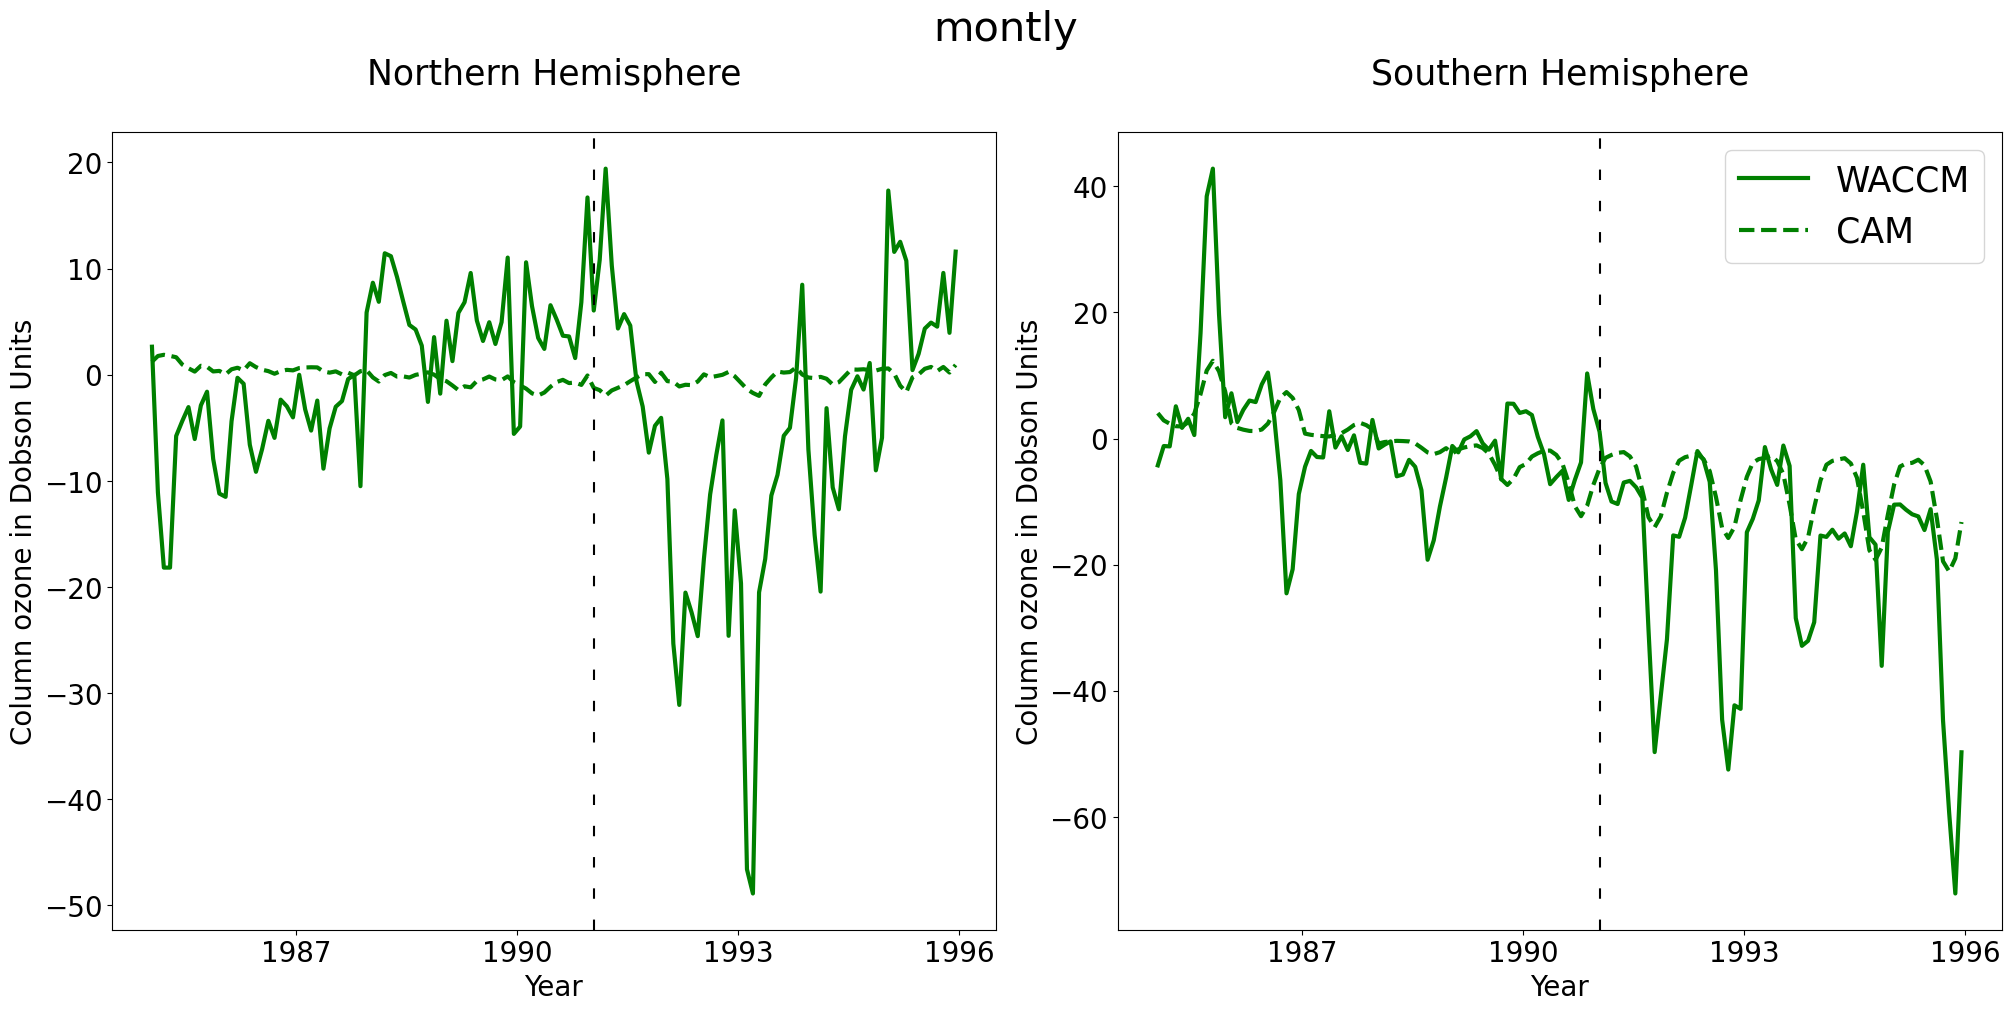

In [367]:
fig, (axs1, axs2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20,10))
#color = ['red','black','blue']
color = ['green','darkviolet','darkorange']

waccm_NH_anom.plot(label="WACCM", ax=axs1, linewidth=3, color='green')
waccm_SH_anom.plot(label='WACCM', ax=axs2, linewidth=3, color='green')

cam_NH_anom.plot(label="CAM", ax=axs1, linestyle='--', linewidth=3, color='green')
cam_SH_anom.plot(label="CAM", ax=axs2, linestyle='--', linewidth=3, color='green')

fig.suptitle('montly', fontsize=30)

axs1.axvline(waccm_NH_anom.isel(time=[12*6]).time.values[0], color='k',linestyle='--',dashes=(5, 10))
axs2.axvline(cam_SH_anom.isel(time=[12*6]).time.values[0], color='k',linestyle='--',dashes=(5, 10))

axs1.set_ylabel(waccm_NH_anom.long_name, fontsize=20)
axs2.set_ylabel(cam_SH_anom.long_name, fontsize=20)

axs1.set_xlabel('Year', fontsize=20)
axs2.set_xlabel('Year', fontsize=20)

axs1.tick_params(axis="x", labelsize=20)
axs2.tick_params(axis="x", labelsize=20)

axs1.tick_params(axis="y", labelsize=20)
axs2.tick_params(axis="y", labelsize=20)

axs1.set_title(" Northern Hemisphere \n" , fontsize=25)
axs2.set_title(" Southern Hemisphere \n" , fontsize=25)

plt.legend(fontsize=25)


In [245]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
waccm_aero = col.search(source_id=['CESM2-WACCM'], experiment_id=['historical'], table_id=['AERmon'], variable_id=['od550aer'])
cam_aero = col.search(source_id=['CESM2'], experiment_id=['historical'], table_id=['AERmon'], variable_id=['od550aer'], member_id=['r1i1p1f1','r2i1p1f1','r3i1p1f1'])

In [246]:
waccm_aero.df
cam_aero.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r2i1p1f1,AERmon,od550aer,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...,NaN,20190308
1,CMIP,NCAR,CESM2,historical,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
2,CMIP,NCAR,CESM2,historical,r3i1p1f1,AERmon,od550aer,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...,NaN,20190308


In [247]:
col = col.search(source_id=['CESM2-WACCM'], experiment_id=['historical'], table_id=['AERmon'])
 
uni_dict = col.unique(['variable_id'])
pprint.pprint(uni_dict, compact=True)
#areacella

{'variable_id': {'count': 35,
                 'values': ['co2', 'mmrsoa', 'o3', 'lossch4', 'va', 'emidms',
                            'ua', 'emiss', 'so2', 'photo1d', 'no', 'mmrso4',
                            'cdnc', 'mmrss', 'emidust', 'cltc', 'mmrdust', 'co',
                            'airmass', 'cod', 'od550aer', 'ptp', 'ps', 'o3prod',
                            'ch4', 'lwp', 'oh', 'no2', 'mmrnh4', 'mmrbc',
                            'o3loss', 'abs550aer', 'mmroa', 'zg', 'lossco']}}


In [248]:
ds_dict_waccm_Aero = waccm_aero.to_dataset_dict(zarr_kwargs={'use_cftime':True})
ds_dict_cam_aero = cam_aero.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [249]:
print(list(ds_dict_waccm_Aero.keys()))
print(list(ds_dict_cam_aero.keys()))
ds_waccm_aero = ds_dict_waccm_Aero['CMIP.NCAR.CESM2-WACCM.historical.AERmon.gn']
ds_cam_aero = ds_dict_cam_aero['CMIP.NCAR.CESM2.historical.AERmon.gn']

['CMIP.NCAR.CESM2-WACCM.historical.AERmon.gn']
['CMIP.NCAR.CESM2.historical.AERmon.gn']


In [250]:
ds_waccm_aero.od550aer

<xarray.DataArray 'od550aer' (member_id: 3, time: 1980, lat: 192, lon: 288)>
dask.array<concatenate, shape=(3, 1980, 192, 288), dtype=float32, chunksize=(1, 309, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
  * member_id  (member_id) <U8 'r2i1p1f1' 'r1i1p1f1' 'r3i1p1f1'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        AOD from ambient aerosols (i.e., includes aerosol water)....
    description:    AOD from ambient aerosols (i.e., includes aerosol water)....
    frequency:      mon
    id:             od550aer
    long_name:      Ambient Aerosol Optical Thickness at 550nm
    mipTable:       AERmon
    out_name:       od550aer
    prov:           AERmon ((isd.003))
    realm:          aerosol
    standard_name:  atmosphere_optical_thickness_due_to_ambient_aerosol_parti...
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Ambient Aerosol Optical Thickness at 550nm
    type:           real
    units:          1
    variable_id:    od550aer

In [251]:
# Select the starting year 5 years prior to the eruption
start_pina = cftime.DatetimeNoLeap(1986,1,15)
end_pina = cftime.DatetimeNoLeap(1996,1,15)

# WACCM
ds_waccm_1986_1996_aero = ds_waccm_aero.sel(time=slice(start_pina, end_pina)).od550aer
# CAM
ds_cam_1986_1996_aero = ds_cam_aero.sel(time=slice(start_pina, end_pina)).od550aer

# Creates a new variable called totO3 for WACCM and CAM 
#ds_waccm_1986_1996_aero = calculate_total_ozone_p(ds_waccm_1986_1996_aero)
#ds_cam_1986_1996_aero = calculate_total_ozone_p(ds_cam_1986_1996_aero)

In [347]:
#ds_waccm_anom_1986_1996_aero_year = calc_yearly_anomaly(ds_waccm_1986_1996_aero,1991)
#ds_cam_anom_1986_1996_aero_year = calc_yearly_anomaly(ds_cam_1986_1996_aero,1991)

ds_waccm_anom_1986_1996_aero = calc_monthly_anomaly(ds_waccm_1986_1996_aero,1991)
ds_cam_anom_1986_1996_aero = calc_monthly_anomaly(ds_cam_1986_1996_aero,1991)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


In [336]:
# Calculate the weight for the northern and southern hemispheres
# WACCM
waccm_NH_anom_aero= computeWeightedMean(ds_waccm_anom_1986_1996_aero.where(ds_waccm_anom_1986_1996_aero['lat']>60.)).compute()
waccm_SH_anom_aero= computeWeightedMean(ds_waccm_anom_1986_1996_aero.where(ds_waccm_anom_1986_1996_aero['lat']<-60.)).compute()

# CAM
cam_NH_anom_aero = computeWeightedMean(ds_cam_anom_1986_1996_aero.where(ds_cam_anom_1986_1996_aero['lat']>60.)).compute()
cam_SH_anom_aero = computeWeightedMean(ds_cam_anom_1986_1996_aero.where(ds_cam_anom_1986_1996_aero['lat']<-60.)).compute()

In [237]:
# Calculate the weight for the northern and southern hemispheres
# WACCM
waccm_NH_anom_aero_year= computeWeightedMean(ds_waccm_anom_1986_1996_aero_year.where(ds_waccm_anom_1986_1996_aero_year['lat']>60.)).compute()
waccm_SH_anom_aero_year= computeWeightedMean(ds_waccm_anom_1986_1996_aero_year.where(ds_waccm_anom_1986_1996_aero_year['lat']<-60.)).compute()

# CAM
cam_NH_anom_aero_year = computeWeightedMean(ds_cam_anom_1986_1996_aero_year.where(ds_cam_anom_1986_1996_aero_year['lat']>60.)).compute()
cam_SH_anom_aero_year = computeWeightedMean(ds_cam_anom_1986_1996_aero_year.where(ds_cam_anom_1986_1996_aero_year['lat']<-60.)).compute()

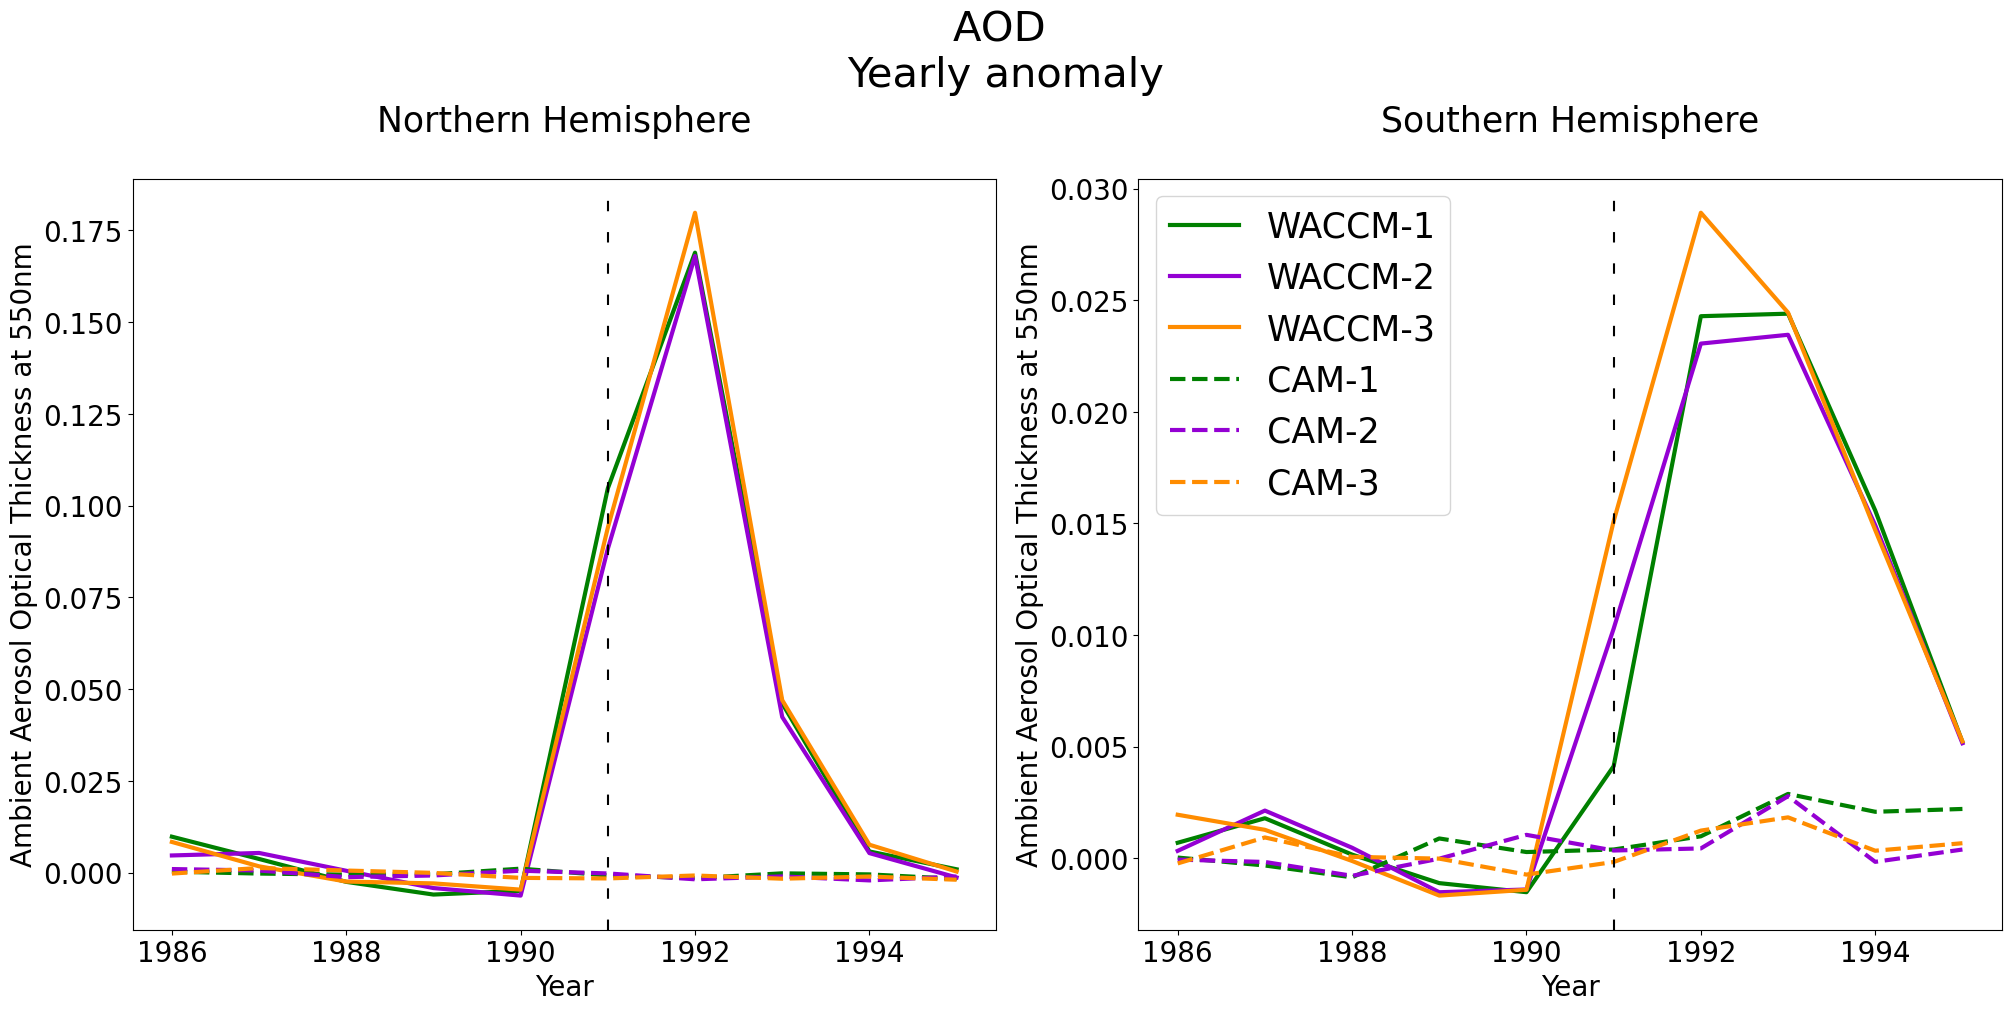

In [341]:
plot_year(waccm_NH_anom_aero_year,waccm_SH_anom_aero_year,cam_NH_anom_aero_year,cam_SH_anom_aero_year,'AOD \nYearly anomaly')

In [10]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
waccm_ptp = col.search(source_id=['CESM2-WACCM'], experiment_id=['historical'], table_id=['AERmon'], variable_id=['ptp'])
cam_ptp = col.search(source_id=['CESM2'], experiment_id=['historical'], table_id=['AERmon'], variable_id=['ptp'], member_id=['r1i1p1f1','r2i1p1f1','r3i1p1f1'])

waccm_ptp.df
cam_ptp.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r2i1p1f1,AERmon,ptp,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...,NaN,20190308
1,CMIP,NCAR,CESM2,historical,r1i1p1f1,AERmon,ptp,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
2,CMIP,NCAR,CESM2,historical,r3i1p1f1,AERmon,ptp,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...,NaN,20190308


In [11]:
ds_dict_waccm_ptp = waccm_ptp.to_dataset_dict(zarr_kwargs={'use_cftime':True})
ds_dict_cam_ptp = cam_ptp.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [13]:
print(list(ds_dict_waccm_ptp.keys()))
print(list(ds_dict_cam_ptp.keys()))
waccm_ptp = ds_dict_waccm_ptp['CMIP.NCAR.CESM2-WACCM.historical.AERmon.gn']
cam_ptp = ds_dict_cam_ptp['CMIP.NCAR.CESM2.historical.AERmon.gn']

['CMIP.NCAR.CESM2-WACCM.historical.AERmon.gn']
['CMIP.NCAR.CESM2.historical.AERmon.gn']
